In [1]:
%autosave 1
import numpy as np
import warnings
from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=FutureWarning)
from scipy.constants import hbar

Autosaving every 1 seconds


[Libreria di riferimento](http://weinbe58.github.io/QuSpin/generated/quspin.basis.spin_basis_1d.html)

We want to write a chain of L coupled qubits:
$$H[h_x(t)] = - \sum_{j=1}^L(JS^z_{j+1}S^z_j+gS^z_j+h_x(t)S^x_j)$$
as in the article we set g=1. 

In the particoular case of single qubit we remove the first term J=0: 

$$H[h_x(t)] = - S^z_j - h_x(t)S^x_j$$

In [2]:
def hamiltonian_eigenprob(hx,L=1,J=1.0,g=1.0,hz=1.0): 
    if L < 2:
        J=0
    else:
        J=J
#     if L>1: 
    # Nel caso di una chain si fa riferimento a symmetries rappresentate da parametri block, capisci meglio.
    basis = spin_basis_1d(L=L,pauli=0,kblock=0,pblock=1) 
    # Voglio usare il il metodo hamiltoniana, come primo argomento gli serve 
    
    z_field=[[g,i] for i in range(L)]
    x_field=[[hx,i] for i in range(L)]
#     hx_discrete = np.arange(start=hx_min, stop=hx_max, step=Δh)
    # la parte dinamica dell' hamiltoniana nella funzione richiede una lista con
    # [["asse",coefficiente,funzione dipendente da t,parametri funzione dipendente da t]]
    J_nn=[[J,i,(i+1)%L] for i in range(L)] # Periodic Boundary Condition
    static=[["zz",J_nn],["z",z_field],["x",x_field]]
    
#     h_values =np.arange(hx_min,hx_max,Δh) # discrete set of possible h fields 
    
#     def operator(time):
#         return h_values[hx_discrete[int(time)]]
    
#     hx_discrete = np.zeros(n_step, dtype=int) # hx_discrete are protocols specified as integers
    
    dynamic=[]
#     fct = lambda time: h_set[hx_discrete[int(time)]]
    # If the operator is time-INdependent, one must pass an empty list: dynamic_list = [].
#     dynamic=[["x",x_field,operator,[]]]
    H=hamiltonian(static,dynamic,static_fmt="dia",dtype=np.float64,basis=basis)
#     print("\n\n-------------------------------> Hamiltonian <-------------------------------")
#     print("")
#     print(H.toarray())
#     print("")
#     print("------------------------------------------------------------------------------")

    eigensystem = H.eigh()
#     print("\n\n---------------------> Eigenvalues, Eigenvectors (in columns)<-------------------------------")
#     print("")
#     print(eigensystem)
#     print("")
#     print("------------------------------------------------------------------------------")
    eigenvectors = eigensystem[1]
    eigenvalues = eigensystem[0]
    return H ,eigenvectors,eigenvalues
hamiltonian_eigenprob(L=1, hx=4)

C:\Users\GUIDA\anaconda3\envs\monti\lib\site-packages\IPython\core\interactiveshell.py:3417: UserWarning: using momentum with L == a
  exec(code_obj, self.user_global_ns, self.user_ns)


Hermiticity check passed!
Symmetry checks passed!


(<quspin.operators.hamiltonian:
 static mat: <2x2 sparse matrix of type '<class 'numpy.float64'>'
 	with 4 stored elements (3 diagonals) in DIAgonal format>
 dynamic:>,
 array([[ 0.61541221, -0.78820544],
        [-0.78820544, -0.61541221]]),
 array([-2.06155281,  2.06155281]))

**STOCHASTIC DESCENT**
1. Start from a random protocol and proposes local field updates at time t choosing uniformly in the interval [0,T].
2. Magnetic field is changed only if increase the fidelity.
3. Number of fidelity evaluation at most $$20 \times T/\delta t$$
4. Repeat with different initial random protocols.

The set of protocols {$h^{\alpha}|\alpha= 1, \dots, N_{real}$} used to calculate the glass-like order parameter.

In [3]:
def modulus_squared_inner_product(psi1,psi2):
    modulus=np.abs(np.dot(np.conj(psi1.T),psi2))
    return modulus**2
def fidelity(psi_target,psi_rec):
    return modulus_squared_inner_product(psi_target, psi_rec)
def infidelity(psi_target,psi_rec):
    return 1 - modulus_squared_inner_product(psi_target, psi_rec)
def update_state(eigenvectors,eigenvalues,psi_in,T):
    c_i = np.array([np.dot(eigenvectors[:,i],psi_in) for i in range(len(psi_in))]) 
    psi_rec = c_i*np.exp(-1j*eigenvalues*T/hbar)*eigenvectors.sum(axis=0)
    return psi_rec

In [4]:
Δt = 0.01
ITERATIONS = 100
NSTEPS = 250
TMAX=4
LIMIT_FED_EVAL=20*TMAX/Δt # set by paper authors

**SPECTRAL METHOD**

First method to evolve the system:

$$|\psi(T)> = \sum_{i=0}^{L-1} c_i exp[-i E_i T / \hbar] |E_i>$$

In [5]:
from random import choices
from random import uniform
from tqdm import tnrange

np.random.seed(213)

hx = [-4,4]
_,vec__H_minus4, val_H_minus4 = hamiltonian_eigenprob(L=1,g=1.0,hz=1.0, hx=-4)
_,vec__H_plus4, val_H_plus4 = hamiltonian_eigenprob(L=1,g=1.0,hz=1.0, hx=4)

random_protocol = np.array(choices(hx, k=NSTEPS)) # Define a random protocol, sampling without replacement from a list. 
angle_phase_iniz = uniform(0,2*np.pi)
angle_phase_target = uniform(0,2*np.pi) 
psi_iniz = 1/np.sqrt(2)*np.array([1,1*np.exp(1j*angle_phase_iniz)]) # Start from a random state 2D
psi_target = 1/np.sqrt(2)*np.array([1,1*np.exp(1j*angle_phase_target)])# Remember to change first component when things will work.
temp_protocol=random_protocol

fidelity_values = []

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


C:\Users\GUIDA\anaconda3\envs\monti\lib\site-packages\IPython\core\interactiveshell.py:3417: UserWarning: using momentum with L == a
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
percentage_flip=20
for j in tnrange(ITERATIONS):
    index_update = np.random.randint(0, NSTEPS-1,size=int(NSTEPS/100*percentage_flip)) # Select an index for the update.
    temp_protocol[[index_update]] = random_protocol[[index_update]]*-1 # Try to update that index.
#     random_protocol[index_update] = random_protocol[index_update]*-1 # Try to update that index.
    temp_psi_iniz = psi_iniz
#     print("")
#     print("temp_psi_iniz",temp_psi_iniz)
#     print("")
    for i in temp_protocol:  # Evolve the random state according to the protocol
        if i<0:
            temp_psi_iniz = update_state(vec__H_minus4,val_H_minus4,temp_psi_iniz,Δt)
        else:
            temp_psi_iniz = update_state(vec__H_plus4,val_H_plus4,temp_psi_iniz,Δt)
    
    fidelity = modulus_squared_inner_product(psi_target,psi_iniz)
    temp_fidelity = modulus_squared_inner_product(psi_target,temp_psi_iniz) # Evaluate the INfidelity
#     print("psi_target",psi_target)
#     print("")
#     print("temp_psi_iniz", temp_psi_iniz )
#     print("")
#     print("modulus_squared_inner_product",modulus_squared_inner_product(psi_target,temp_psi_iniz) )
    
    if temp_fidelity>fidelity: # Update the change only if worse INfidelity
        psi_iniz = temp_psi_iniz 
        random_protocol=temp_protocol
        fidelity=temp_fidelity
        print("HO AGGIORNATO")
    fidelity_values.append(fidelity)

# saved_param_adam = np.array(saved_param_adam).transpose()
# np.savetxt('Model_2_lambdas_iterations.txt', saved_param_adam, delimiter = ',',header="Each column is the set of the lambda parameters, the first column refers to the first iteration and so forth.")

    

C:\Users\GUIDA\anaconda3\envs\monti\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


HO AGGIORNATO
HO AGGIORNATO



In [16]:
1-np.array(fidelity_values)

array([ 0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,
        0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,
        0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,
        0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,
        0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,
        0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,
        0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,
        0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,
        0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,
        0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,
        0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,
        0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,
        0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,
        0.0830017 ,  0.0830017 ,  0.0830017 ,  0.0830017 ,  0.08

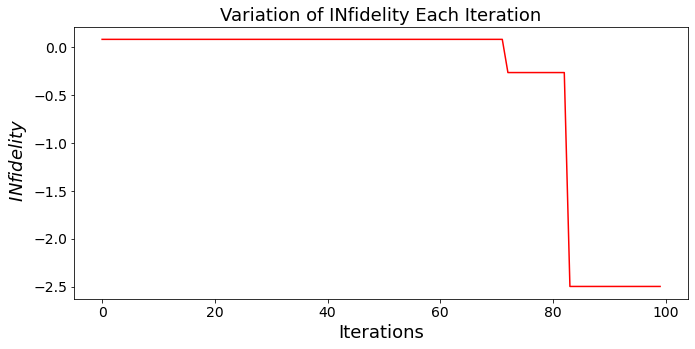

In [13]:
fig, ax = plt.subplots(figsize=(11,5))
ax.plot(1-np.array(fidelity_values),color='r')
ax.set_title(r"Variation of INfidelity Each Iteration", fontsize=18)
ax.set_xlabel("Iterations", fontsize=18)
ax.set_ylabel(r" $INfidelity$", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14) 